# Dense Network

In [1]:
import torch
torch.set_default_dtype(torch.float64)

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"]=(10,7)

# comment out the below if don"t have a 4k or retina display
%config InlineBackend.figure_format="retina"

# Data 

In [3]:
from google.colab import files 
uploaded = files.upload() 

Saving egg_times.csv to egg_times.csv


In [4]:
egg_timing_df = pd.read_csv("egg_times.csv",index_col=0)
egg_timing_df.head(n=10)

,weight,time,outcome
0,55.0,7.1,2
1,55.2,2.8,0
2,59.2,5.1,2
3,47.3,2.1,0
4,62.9,6.8,2
5,51.0,3.0,0
6,58.6,6.4,2
7,52.4,1.5,0
8,55.3,4.6,2
9,56.5,4.8,1


In [5]:
max(egg_timing_df["weight"])

69.5

In [6]:
np.mean(egg_timing_df["weight"])

55.06291079812208

In [7]:
np.std(egg_timing_df["weight"])

5.0245517689382995

In [8]:
egg_timing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 0 to 638
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   weight   639 non-null    float64
 1   time     639 non-null    float64
 2   outcome  639 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 20.0 KB


In [9]:
train_ = egg_timing_df[["weight","time"]].values # TensorFlow/Keras likes numpy/arrays rather than Dataframes
target_ = egg_timing_df["outcome"].values #.to_numpy()

train_in = train_[:-50] # get all except the last 50 for training
train_target = target_[:-50]

val_in = train_[-50:] # take all from the last 50 for validation
val_target = target_[-50:]

In [10]:
n = len(target_)
num_underdone = sum(target_==0)
print(num_underdone)
num_softboiled = sum(target_==1)
print(num_softboiled)
num_hardboiled = sum(target_==2)
print(num_hardboiled)

# class_weights = {0:underdone_class_weight, 1:softboiled_class_weight, 2: hardboiled_class_weight}

202
117
320


In [11]:
underdone = egg_timing_df[egg_timing_df["outcome"]==0][:117]
softboiled = egg_timing_df[egg_timing_df["outcome"]==1]
hardboiled = egg_timing_df[egg_timing_df["outcome"]==2][:117]

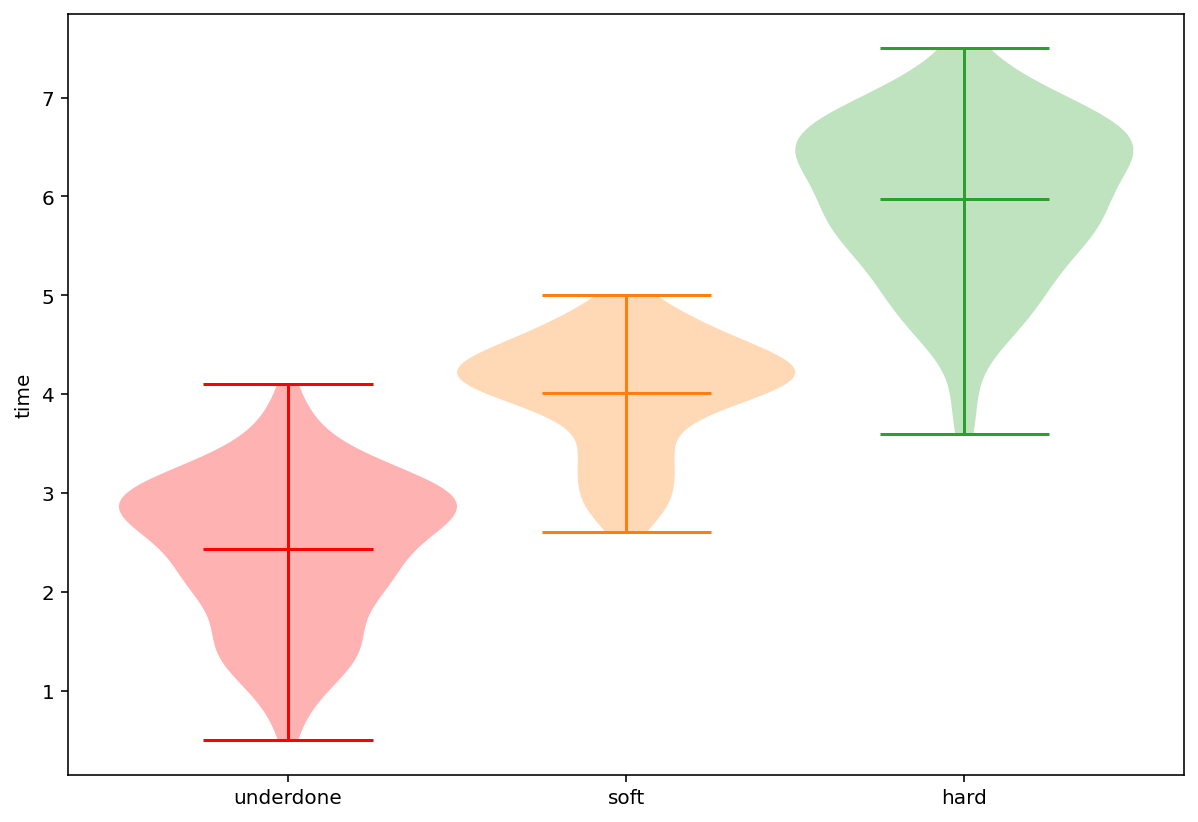

In [12]:
violin_parts = plt.violinplot(underdone['time'], positions=[0], showmeans=True)
# over-ride default blue color, you can't use 'color' parameter as can on histograms etc
for pc in violin_parts['bodies']: # used to
    pc.set_facecolor('red')
    violin_parts['cbars'].set_edgecolor('red')
    violin_parts['cmaxes'].set_edgecolor('red')
    violin_parts['cmins'].set_edgecolor('red')
    violin_parts['cmeans'].set_edgecolor('red')
    plt.violinplot(softboiled['time'], positions=[0.5], showmeans=True)
    plt.violinplot(hardboiled['time'], positions=[1], showmeans=True)
    plt.ylabel("time")
    plt.xticks([0,0.5,1],["underdone", "soft", "hard"])

In [13]:
len(train_)

639

In [14]:
class EggTimesDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, df):

        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        features = self.df.iloc[idx, :-1].values
        outcomes = np.array(self.df.iloc[idx, -1])

        example = {"features": features, "outcomes": outcomes}

        return example

train_dataset = EggTimesDataset(egg_timing_df[:-50])
test_dataset = EggTimesDataset(egg_timing_df[-50:])

In [15]:
train_dataset[0]

{'features': array([55. ,  7.1]), 'outcomes': array(2)}

In [16]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=50,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=50,
                                          shuffle=True, num_workers=2)

# Dense model

In [17]:
# Original
class DenseModel(nn.Module):
    def __init__(self, num_in):

        super(DenseModel, self).__init__()

        self.fc1 = nn.Linear(num_in, 32)
        self.fc2 = nn.Linear(32, 6)
        self.fc3 = nn.Linear(6, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

dense = DenseModel(2)

Comment out other model definition for choosing model to train

In [46]:
# Modification 1
# 4 layer, sigmoid, more parameters
'''
class DenseModel(nn.Module):
    def __init__(self, num_in):

        super(DenseModel, self).__init__()

        self.fc1 = nn.Linear(num_in, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

dense = DenseModel(2)
'''

In [112]:
# Modification 2
# 5 layer, tan h, more parameters
'''
class DenseModel(nn.Module):
    def __init__(self, num_in):

        super(DenseModel, self).__init__()

        self.fc1 = nn.Linear(num_in, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

dense = DenseModel(2)
'''

In [163]:
# Modification 3
# 4 layer, gelu, more parameters
'''
class DenseModel(nn.Module):
    def __init__(self, num_in):

        super(DenseModel, self).__init__()

        self.fc1 = nn.Linear(num_in, 128)
        self.fc2 = nn.Linear(128, 48)
        self.fc3 = nn.Linear(48, 12)
        self.fc4 = nn.Linear(12, 3)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = self.fc4(x)
        return x

dense = DenseModel(2)
'''

In [164]:
print(dense)

DenseModel(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=12, bias=True)
  (fc4): Linear(in_features=12, out_features=3, bias=True)
)


### Setup for training

In [165]:
learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense.parameters(), lr=learning_rate) # note this uses *Pytorch* optim not Pyro

### training loop 

In [166]:
maximum = 0.0
for epoch in range(800): 

    running_loss = []
    for i, batch in enumerate(trainloader):
        
        inputs = batch["features"]
        labels = batch["outcomes"]

        optimizer.zero_grad()

        outputs = dense(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        freq_checks = 1
    if epoch % freq_checks == 0:
        print("epoch: {} loss: {:.3f}".format(epoch, sum(running_loss) / len(running_loss)))
        #running_loss = []
        for data in testloader:
            test_inputs = data["features"]
            test_labels = data["outcomes"]
            outputs = dense(test_inputs)
            _, predicted = torch.max(outputs, 1)
            print("Test accuracy:", sum(np.array(predicted)==np.array(test_labels))/len(predicted))
            maximum = max(sum(np.array(predicted)==np.array(test_labels))/len(predicted), maximum)
print("Final loss:{:.3f} at epoch: {} and learning rate: {}".format(sum(running_loss)/len(running_loss),epoch,learning_rate))

epoch: 0 loss: 1.183
Test accuracy: 0.38
epoch: 1 loss: 0.963
Test accuracy: 0.38
epoch: 2 loss: 0.889
Test accuracy: 0.38
epoch: 3 loss: 0.834
Test accuracy: 0.38
epoch: 4 loss: 0.776
Test accuracy: 0.54
epoch: 5 loss: 0.684
Test accuracy: 0.82
epoch: 6 loss: 0.607
Test accuracy: 0.8
epoch: 7 loss: 0.532
Test accuracy: 0.76
epoch: 8 loss: 0.476
Test accuracy: 0.8
epoch: 9 loss: 0.431
Test accuracy: 0.8
epoch: 10 loss: 0.406
Test accuracy: 0.82
epoch: 11 loss: 0.369
Test accuracy: 0.86
epoch: 12 loss: 0.342
Test accuracy: 0.86
epoch: 13 loss: 0.325
Test accuracy: 0.84
epoch: 14 loss: 0.305
Test accuracy: 0.9
epoch: 15 loss: 0.293
Test accuracy: 0.84
epoch: 16 loss: 0.290
Test accuracy: 0.84
epoch: 17 loss: 0.284
Test accuracy: 0.9
epoch: 18 loss: 0.287
Test accuracy: 0.8
epoch: 19 loss: 0.272
Test accuracy: 0.9
epoch: 20 loss: 0.242
Test accuracy: 0.84
epoch: 21 loss: 0.256
Test accuracy: 0.84
epoch: 22 loss: 0.310
Test accuracy: 0.76
epoch: 23 loss: 0.246
Test accuracy: 0.84
epoch: 24

In [167]:
print(maximum)

0.9
